In [18]:
import pandas as pd
import os
import numpy as np
from collections import Counter
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42  # For PDF: embed text as text, not paths
plt.rcParams['svg.fonttype'] = 'none'  # For SVG: embed text as text, not paths

This notebook is for parsing and mapping localization annotations from Lacoste, J. et al. (2024) *Perfasive mislocalization of pathogenic coding variants underlying human disorders*. Cell, 187(23), 6725-6741. <br>

The metadata is the supplementary spreadsheet, downloadable here: https://www.cell.com/cell/abstract/S0092-8674(24)01021-3?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867424010213%3Fshowall%3Dtrue <br>

In [19]:
FIG_DIR = "../../figures/variant"
os.makedirs(FIG_DIR, exist_ok=True)

In [20]:
def write_fasta(fasta_name, keys, sequences):
    with open(fasta_name, "w") as f:
        for i, key in enumerate(keys):
            seq = sequences[i]
            f.write(f">{key}\n")
            f.write(f"{seq}\n")

def swap_mutation(seq, residue, new_residue, position):
    if len(seq) >= position and seq[position-1] == residue:
        seq = list(seq)
        seq[position-1] = new_residue #SUBTRACT 1 FROM POSITON
        return "".join(seq)
    else:
        return pd.NA

def parse_mutation(gene_name, sequence):
    if " " not in gene_name: #Wild-type
        return sequence 
    #TODO: Figure out the following edge cases
    if gene_name == "EGFR L747-E749del, A750P" or gene_name == "EGFR D770-N771 insNPG": 
        return pd.NA
    elif gene_name == "EGFR L858R, T790M":
        return pd.NA
    elif gene_name == "EGFR vIII":
        return pd.NA
    elif gene_name == "FLT3 ITD":
        return pd.NA
    elif gene_name == "MTOR kin":
        return pd.NA
    elif gene_name == "LMNA (progerin)":
        return pd.NA
    elif gene_name == "B2M M1?":
        return pd.NA
    else:
        gene_name = gene_name.replace(",", "")
        split = gene_name.split(" ")
        gene = split[0]
        mutations = split[1:]
        for mutation in mutations:
            res = mutation[0]
            position = int(mutation[1:-1])
            new_res = mutation[-1]
            sequence = swap_mutation(sequence, res, new_res, position)
        return sequence

def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

In [21]:
metadata = pd.read_csv("../../datasets/raw/Lacoste_metadata_raw.csv")
print(f"Number of unique genes: {metadata.Gene.nunique()}")
print(f"Number of unique variants: {metadata.Variant.nunique()}")
print(f"Number of mislocalized variants: {metadata[metadata.Mislocalized == 1].shape[0]}")

Number of unique genes: 1269
Number of unique variants: 3445
Number of mislocalized variants: 250


In [22]:
metadata = pd.read_csv("../../datasets/raw/Lacoste_metadata_raw.csv")
print(f"Total of {len(metadata)} genes and mutated genes")
print(f"{len(metadata[metadata.Sequence.notnull()])}/{len(metadata)} genes have sequences")
metadata = metadata[metadata.Sequence.notnull()]

Total of 3448 genes and mutated genes
3313/3448 genes have sequences


In [23]:
len(set(metadata.Variant.unique()) - set(metadata.Gene.unique()))

3310

MPDU1 and FBLN5 have inconsistent original locations. <br>
MPDU1 localizes to ER according to HPA, so we correct it. <br>
FBLN5 is secreted according to HPA, so we exclude it. <br>

In [24]:
display(metadata[(metadata.Gene == "FBLN5") | (metadata.Gene == "MPDU1")])

metadata = metadata[metadata.Gene != "FBLN5"]
metadata.loc[metadata.Gene == "MPDU1", "Mislocalization phenotype"] = "ER>Golgi apparatus"
print(f"Now there are {len(metadata)} genes left")

,Unnamed: 0,Gene,Variant,Variant (alternative),Collection,Phenotype annotation,dbSNP_ID,Uniprot,Mislocalized,Mislocalization phenotype,...,AlphaMissense class,GnomAD VEP frequency,Inheritance,ClinVar class,PPI phenotype,PTM residue,PTM type,Disulfide bond,HeLa expression (TPM),Sequence
1143,1143,FBLN5,FBLN5 G412E,NaN,hmORFeome 1.1,Age-related macular degeneration,rs121434303,Q9UBX5,0.0,NaN,...,pathogenic,0.000000,autosomal recessive,Pathogenic/Likely pathogenic,NaN,NaN,NaN,NaN,24.9,MPGIKRILTVTILALCLPSPGNAQAQCTNGFDLDRQSGQCLDIDEC...
1144,1144,FBLN5,FBLN5 Q124P,NaN,hmORFeome 1.1,Age-related macular degeneration,NaN,Q9UBX5,0.0,NaN,...,pathogenic,0.000000,autosomal recessive,No data,NaN,NaN,NaN,NaN,24.9,MPGIKRILTVTILALCLPSPGNAQAQCTNGFDLDRQSGQCLDIDEC...
1145,1145,FBLN5,FBLN5 S227P,NaN,hmORFeome 1.1,Cutis laxa,rs28939370,Q9UBX5,1.0,Golgi>ER,...,pathogenic,0.000000,autosomal recessive,Pathogenic/Likely pathogenic,NaN,NaN,NaN,NaN,24.9,MPGIKRILTVTILALCLPSPGNAQAQCTNGFDLDRQSGQCLDIDEC...
1146,1146,FBLN5,FBLN5 V60L,NaN,hmORFeome 1.1,Age-related macular degeneration,rs121434299,Q9UBX5,1.0,Vesicles>ER,...,pathogenic,0.000012,autosomal recessive,VUS,Quasi-null,NaN,NaN,NaN,24.9,MPGIKRILTVTILALCLPSPGNAQAQCTNGFDLDRQSGQCLDIDEC...
2032,2032,MPDU1,MPDU1 G73E,NaN,hmORFeome 1.1,Congenital disorder of glycosylation 1f,rs104894586,O75352,1.0,ER>Golgi apparatus,...,pathogenic,0.000012,autosomal recessive,Conflicting,NaN,NaN,NaN,NaN,78.1,MAAEADGPLKRLLVPILLPEKCYDQLFVQWDLLHVPCLKILLSKGL...
2033,2033,MPDU1,MPDU1 L119P,NaN,hmORFeome 1.1,Congenital disorder of glycosylation 1f,rs104894587,O75352,1.0,Golgi apparatus>ER,...,pathogenic,0.000000,autosomal recessive,Pathogenic/Likely pathogenic,NaN,NaN,NaN,NaN,78.1,MAAEADGPLKRLLVPILLPEKCYDQLFVQWDLLHVPCLKILLSKGL...
2034,2034,MPDU1,MPDU1 L74S,NaN,hmORFeome 1.1,Congenital disorder of glycosylation 1f,rs104894589,O75352,1.0,ER>Golgi apparatus,...,pathogenic,0.000008,autosomal recessive,Pathogenic/Likely pathogenic,NaN,NaN,NaN,NaN,78.1,MAAEADGPLKRLLVPILLPEKCYDQLFVQWDLLHVPCLKILLSKGL...


Now there are 3309 genes left


Now we want to separate variants that showed mislocalization versus those that didn't <br>
Metadata "Mislocalization" column - 1 = mislocalized, 0 = normally localized, NA = not applicable (either WT or variant not expressed) <br>
We drop all genes with NA for mislocalization

In [25]:
print(f"{len(metadata[metadata.Mislocalized.isna()])}/{len(metadata)} genes have NA Mislocalization and we drop them")
metadata = metadata[metadata.Mislocalized.notna()]

1145/3309 genes have NA Mislocalization and we drop them


Now we separate stationary vs mislocalized variants and extract the wild-type localization annotations

Not all mutated sequences can be parsed because they either 
1. assume a residue at a position that disagrees with the UniProt canonical sequence or 
2. reference a residue position that is higher than the length of the UniProt canonical sequence <br>

We only keep genes with at least one variant whose sequence we successfully parsed

In [26]:
stationary = metadata[metadata.Mislocalized == 0].copy()
mislocalized = metadata[metadata.Mislocalized == 1].copy()

#Get wild-type and mutated localizations for mislocalized genes
locations = mislocalized["Mislocalization phenotype"].str.split(">")
original_locs = []
mutated_locs = []
for loc in locations:
    original = ";".join([l.strip() for l in loc[0].split(",")])
    mutated = ";".join([l.strip() for l in loc[1].split(",")])
    original_locs.append(original)
    mutated_locs.append(mutated)
mislocalized.loc[:, "original_locs"] = original_locs
mislocalized.loc[:, "mutated_locs"] = mutated_locs


#Construct dataframe for wild-type genes
original = pd.DataFrame(
            np.array([
                mislocalized.Uniprot.to_list(),
                mislocalized.Gene.to_list(),
                mislocalized.Gene.to_list(),
                mislocalized.original_locs.to_list(),
                mislocalized.Sequence.to_list()
            ]).T, 
            columns=["Uniprot", "Gene", "Variant", "location", "Sequence"]
            ).drop_duplicates()
original.loc[:, "mislocalized"] = False
original.loc[:, "mutated"] = False
original_loc_dict = original.set_index("Gene").location.to_dict()

#Construct dataframe for mislocalized variants
mutated = pd.DataFrame(
            np.array([
                mislocalized.Uniprot.to_list(),
                mislocalized.Gene.to_list(),
                mislocalized.Variant.to_list(),
                mislocalized.mutated_locs.to_list(),
                mislocalized.Sequence.to_list()
            ]).T, 
            columns=["Uniprot", "Gene", "Variant", "location", "Sequence"]
            )
mutated.loc[:, "mislocalized"] = True
mutated.loc[:, "mutated"] = True
mutated["Sequence"] = mutated.apply(lambda x: parse_mutation(x.Variant, x.Sequence), axis=1)
print(f"{len(mutated.dropna())}/{len(mutated)} mutated gene sequences successfully parsed")
mutated = mutated.dropna()


#Combine wild-type and mislocalized variant dataframe
df = pd.concat([original, mutated])
temp = df.Gene.value_counts()
print(f"Keep {len(df[df.Gene.isin(temp[temp>1].index)])}/{len(df)} genes with variants are kept")
df = df[df.Gene.isin(temp[temp>1].index)] #drop genes whose variant got cut above


#Collect stationary variants and add to dataframe
temp = stationary[stationary.Gene.isin(df.Gene.unique())]
temp = pd.DataFrame(
            np.array([
                temp.Uniprot.to_list(),
                temp.Gene.to_list(),
                temp.Variant.to_list(),
                temp.Sequence.to_list()
            ]).T, 
            columns=["Uniprot", "Gene", "Variant", "Sequence"]
            )

temp.loc[:, "location"] = temp.Gene.map(original_loc_dict)
temp.loc[:, "mislocalized"] = False
temp.loc[:, "mutated"] = True
temp["Sequence"] = temp.apply(lambda x: parse_mutation(x.Variant, x.Sequence), axis=1)
temp = temp.dropna()

df = pd.concat([df, temp])

212/241 mutated gene sequences successfully parsed
Keep 346/360 genes with variants are kept


In [27]:
# Map LaCoste annotation label to our level1 labels
mapping = {
    'ER': 'endoplasmic-reticulum',
    'Cytoplasm': 'cytosol',
    'Plasma membrane': 'plasma-membrane',
    'Foci': '',  # ?
    'Golgi apparatus': 'golgi-apparatus',
    'nucleus': 'nucleoplasm',
    'Nucleus': 'nucleoplasm',
    'Mitochondria': 'mitochondria',
    'Vesicles': 'vesicles',
    'Cellular periphery': 'plasma-membrane',  # ?
    'Intermediate filaments': 'intermediate-filaments',
    'Actin': 'actin-filaments',
    'Tubulin': 'microtubules',
    'Rods & rings': '',  # ?
    'Nuclear membrane': 'nuclear-membrane',
    'Nucleolus': 'nucleoli',
    'Nuclear periphery': 'nuclear-membrane',  # ?
    'Golgi': 'golgi-apparatus'
}

def map_locs(locs, mapping):
    locs = locs.split(";")
    new_locs = []
    for loc in locs:
        if loc in mapping:
            new_locs.append(mapping[loc])
    return ";".join(new_locs)


df.loc[:, "level1"] = df.location.apply(map_locs, args=(mapping,))

Now we add the hierarchical "cytoskeleton" label to the level1 annotations. And then add level2 and level3 annotations

In [28]:
def add_cystoskeleton(locs):
    locs = locs.split(";")
    if {"actin-filaments", "intermediate-filaments", "microtubules"}.intersection(set(locs)):
        locs = ["cytoskeleton"] + locs
    return ";".join(locs)

df.loc[:, "level1"] = df.level1.apply(add_cystoskeleton)

def map_list(locations, map, sep=";"):
    if locations == '':
        return ''
    locations = locations.split(sep)
    locations = [map[loc] for loc in locations if map[loc]!='']
    locations = list(np.unique(locations))
    return ";".join(locations)


mappings = load_config("../../datasets/final/hierarchical_lable_set.yaml")
df.loc[:, "level2"] = df.level1.apply(lambda x: map_list(x, mappings["lvl1_to_lvl2"]))
df.loc[:, "level3"] = df.level1.apply(lambda x: map_list(x, mappings["lvl1_to_lvl3"]))

Now we exclude genes and variants if the original location cannot be mapped to level1 labels

In [29]:
num_genes = len(df)
bad_genes = df[(df.mutated) & (df.level1 == "")].Gene.unique() 
df = df[~df.Gene.isin(bad_genes)]#cannot include variants if original location is not in mapping
df = df[df.level1 != ""] #drop variants with no level1 location
print(f"We keep {len(df)}/{num_genes} genes")

We keep 417/533 genes


We only keep genes if the have at least one variant included in the filtered data

In [30]:
original_genes = set(df[~df.mutated].Gene.unique())
mutated_genes = set(df[df.mutated].Gene.unique())
all_genes = original_genes.intersection(mutated_genes)
df = df[df.Gene.isin(all_genes)]

assert (df.groupby("Gene")["mutated"].nunique() == 2).all()#every gene should have wildtype plus at least 1 variant

print(f"We look at {df.Gene.nunique()} genes")
print("And " + str(len(df[df["mutated"]])) + " variants")
print(str(len(df[df["mislocalized"]])) + " variants are mislocalized")
print(str(len(df[(df["mutated"])& (~df["mislocalized"])]))  + " variants are not mislocalized")

We look at 103 genes
And 308 variants
169 variants are mislocalized
139 variants are not mislocalized


In [31]:
write_fasta("../../datasets/fastas/lacoste.fasta", df.Variant.to_list(), df.Sequence.to_list())
df.reset_index(drop=True, inplace=True)
df.to_csv("../../datasets/final/lacoste_metadata.csv", index=False)

Visualize the Frequency of level1 labels in the Lacoste data

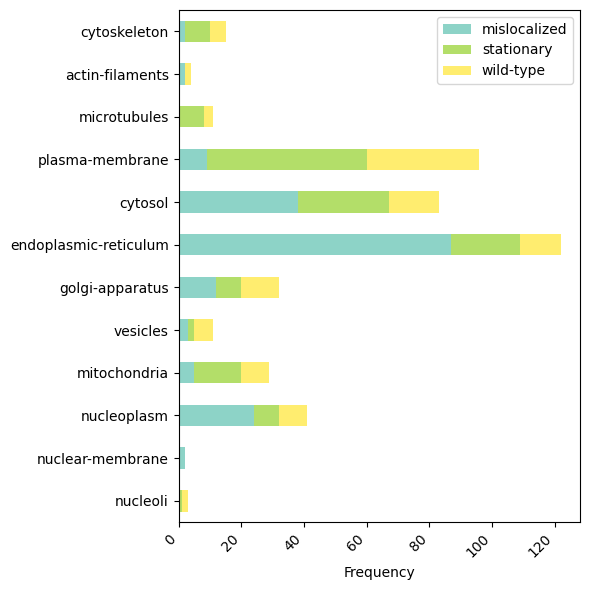

In [32]:
ordered_labels_level1 = [
                "cytoskeleton",
                "actin-filaments",
                "intermediate-filaments",
                "centrosome",
                "microtubules",
                "plasma-membrane",
                "cytosol",
                "endoplasmic-reticulum",
                "golgi-apparatus",
                "vesicles",
                "endosomes",
                "lysosomes",
                "peroxisomes",
                "lipid-droplets",
                "mitochondria",
                "nucleoplasm",
                "nuclear-bodies",
                "nuclear-membrane",
                "nuclear-speckles",
                "nucleoli",
                "nucleoli-fibrillar-center",
                #"plastid"
                ]

def categorize(row):
    if row['mislocalized']:
        return 'mislocalized'
    elif row['mutated']:
        return 'stationary'
    else:
        return 'wild-type'

#Separate annotations from multilocalizing genes for the purpose of displaying frequency
temp = []
for i, r in df.iterrows():
    locs = r.level1.split(";")
    for loc in locs:
        temp.append([r.Uniprot, r.mislocalized, r.mutated, loc])
temp = pd.DataFrame(temp, columns=["Uniprot", "mislocalized", "mutated", "level1"])

temp['category'] = temp.apply(categorize, axis=1)
count_df = temp.groupby(['level1', 'category']).size().unstack(fill_value=0)
count_df = count_df[['mislocalized', 'stationary', 'wild-type']]

order = [lab for lab in ordered_labels_level1 if lab in temp.level1.unique()]
count_df = count_df.loc[order[::-1]]

count_df.plot(kind='barh', stacked=True, figsize=(6, 6), colormap='Set3')
plt.xlabel('Frequency')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.savefig(f"{FIG_DIR}/lacoste_frequency_level1.pdf", bbox_inches='tight', dpi=300)


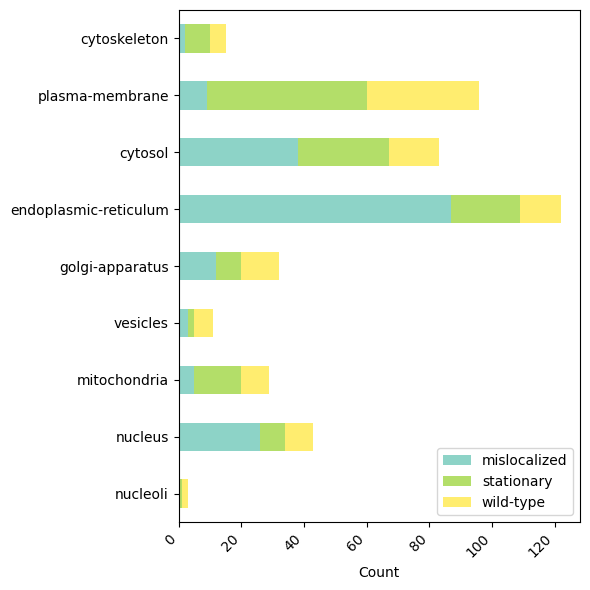

In [33]:
ordered_labels_level2 = [
                "cytoskeleton",
                "plasma-membrane",
                "cytosol",
                "endoplasmic-reticulum",
                "golgi-apparatus",
                "vesicles",
                "mitochondria",
                "nucleus",
                "nucleoli",
                #"plastid"
                ]

def categorize(row):
    if row['mislocalized']:
        return 'mislocalized'
    elif row['mutated']:
        return 'stationary'
    else:
        return 'wild-type'

#Separate annotations from multilocalizing genes for the purpose of displaying frequency
temp = []
for i, r in df.iterrows():
    locs = r.level2.split(";")
    for loc in locs:
        temp.append([r.Uniprot, r.mislocalized, r.mutated, loc])
temp = pd.DataFrame(temp, columns=["Uniprot", "mislocalized", "mutated", "level2"])

temp['category'] = temp.apply(categorize, axis=1)
count_df = temp.groupby(['level2', 'category']).size().unstack(fill_value=0)
count_df = count_df[['mislocalized', 'stationary', 'wild-type']]

order = [lab for lab in ordered_labels_level2 if lab in temp.level2.unique()]
count_df = count_df.loc[order[::-1]]

count_df.plot(kind='barh', stacked=True, figsize=(6, 6), colormap='Set3')
plt.xlabel('Count')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.savefig(f"{FIG_DIR}/lacoste_frequency_level2.pdf", dpi=300)


Now we want to check if the localization annnotations from Lacoste match with the ones we have collected from HPA, OpenCell and/or UniProt

In [34]:
all_mapped_data = pd.read_csv("../../datasets/intermediate/mapped_locations_all_datasets.csv")

In [35]:
df[~ df.mutated]

,Uniprot,Gene,Variant,location,Sequence,mislocalized,mutated,level1,level2,level3
0,P60709,ACTB,ACTB,Actin,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,False,False,cytoskeleton;actin-filaments,cytoskeleton,cytoskeleton
1,O43707,ACTN4,ACTN4,Actin,MVDYHAANQSYQYGPSSAGNGAGGGGSMGDYMAQEDDWDRDLLLDP...,False,False,cytoskeleton;actin-filaments,cytoskeleton,cytoskeleton
2,P37023,ACVRL1,ACVRL1,Plasma membrane,MTLGSPRKGLLMLLMALVTQGDPVKPSRGPLVTCTCESPHCKGPTC...,False,False,plasma-membrane,plasma-membrane,plasma-membrane
3,Q15848,ADIPOQ,ADIPOQ,Vesicles,MLLLGAVLLLLALPGHDQETTTQGPGVLLPLPKGACTGWMAGIPGH...,False,False,vesicles,vesicles,endomembrane-system
4,P07550,ADRB2,ADRB2,Plasma membrane,MGQPGNGSAFLLAPNGSHAPDHDVTQERDEVWVVGMGIVMSLIVLA...,False,False,plasma-membrane,plasma-membrane,plasma-membrane
...,...,...,...,...,...,...,...,...,...,...
98,Q6PIZ9,TRAT1,TRAT1,Nucleus,MSGISGCPFFLWGLLALLGLALVISLIFNISHYVEKQRQDKMYSYS...,False,False,nucleoplasm,nucleus,nucleus
99,Q71U36,TUBA1A,TUBA1A,Tubulin,MRECISIHVGQAGVQIGNACWELYCLEHGIQPDGQMPSDKTIGGGD...,False,False,cytoskeleton;microtubules,cytoskeleton,cytoskeleton
100,Q9BVA1,TUBB2B,TUBB2B,Tubulin,MREIVHIQAGQCGNQIGAKFWEVISDEHGIDPTGSYHGDSDLQLER...,False,False,cytoskeleton;microtubules,cytoskeleton,cytoskeleton
101,P06132,UROD,UROD,Cytoplasm,MEANGLGPQGFPELKNDTFLRAAWGEETDYTPVWCMRQAGRYLPEF...,False,False,cytosol,cytosol,cytosol


In [36]:
all_data = pd.read_csv("../../datasets/intermediate/all_data_w_folds.csv")
hpa_uniprot_combined_trainset = all_data[all_data.hpa_uniprot_combined_trainset][['uniprot_id', 'combined_level1', 'combined_level2', 'combined_level3']]
temp = df[~df.mutated].merge(hpa_uniprot_combined_trainset, left_on="Uniprot", right_on="uniprot_id")
print(f"{len(temp)}/{len(df[~ df.mutated])} of Lacoste wild-type genes included in hpa_uniprot_combined_trainset")

for col in temp.columns:
    if f"level" in col:
        temp[col] = temp[col].apply(lambda s: set(s.split(";")) if pd.notnull(s) else {})

for level in [1,2,3]:
    level = f"level{level}"
    new_col = f"inter_{level}"
    temp.loc[:, new_col] = temp.apply(lambda r: r.level1.intersection(r.combined_level1), axis=1)

temp[temp['inter_level1'].apply(lambda x: x == set())]

45/103 of Lacoste wild-type genes included in hpa_uniprot_combined_trainset


,Uniprot,Gene,Variant,location,Sequence,mislocalized,mutated,level1,level2,level3,uniprot_id,combined_level1,combined_level2,combined_level3,inter_level1,inter_level2,inter_level3
2,Q16671,AMHR2,AMHR2,Plasma membrane,MLGSLGLWALLPTAVEAPPNRRTCVFFEAPGVRGSTKTLGELLDTG...,False,False,{plasma-membrane},{plasma-membrane},{plasma-membrane},Q16671,"{vesicles, cytosol, nucleoplasm}","{nucleus, cytosol, vesicles}","{nucleus, cytosol, endomembrane-system}",{},{},{}
10,P58418,CLRN1,CLRN1,Vesicles,MPSQQKKIIFCMAGVFSFACALGVVTALGTPLWIKATVLCKTGALL...,False,False,{vesicles},{vesicles},{endomembrane-system},P58418,{plasma-membrane},{plasma-membrane},{plasma-membrane},{},{},{}
12,Q9Y215,COLQ,COLQ,Vesicles,MVVLNPMTLGIYLQLFFLSIVSQPTFINSVLPISAALPSLDQKKRG...,False,False,{vesicles},{vesicles},{endomembrane-system},Q9Y215,{plasma-membrane},{plasma-membrane},{plasma-membrane},{},{},{}
16,P11362,FGFR1,FGFR1,ER,MWSWKCLLFWAVLVTATLCTARPSPTLPEQAQPWGAPVEVESFLVH...,False,False,{endoplasmic-reticulum},{endoplasmic-reticulum},{endomembrane-system},P11362,"{microtubules, cytoskeleton}",{cytoskeleton},{cytoskeleton},{},{},{}
17,P21802,FGFR2,FGFR2,Golgi apparatus,MVSWGRFICLVVVTMATLSLARPSFSLVEDTTLEPEEPPTKYQISQ...,False,False,{golgi-apparatus},{golgi-apparatus},{endomembrane-system},P21802,"{nucleoplasm, vesicles, plasma-membrane}","{nucleus, vesicles, plasma-membrane}","{nucleus, plasma-membrane, endomembrane-system}",{},{},{}
19,P18507,GABRG2,GABRG2,ER,MSSPNIWSTGSSVYSTPVFSQKMTVWILLLLSLYPGFTSQKSDDDY...,False,False,{endoplasmic-reticulum},{endoplasmic-reticulum},{endomembrane-system},P18507,{plasma-membrane},{plasma-membrane},{plasma-membrane},{},{},{}
22,P42701,IL12RB1,IL12RB1,ER,MEPLVTWVVPLLFLFLLSRQGAACRTSECCFQDPPYPDADSGSASG...,False,False,{endoplasmic-reticulum},{endoplasmic-reticulum},{endomembrane-system},P42701,{plasma-membrane},{plasma-membrane},{plasma-membrane},{},{},{}
25,P23276,KEL,KEL,ER,MEGGDQSEEEPRERSQAGGMGTLWSQESTPEERLPVEGSRPWAVAR...,False,False,{endoplasmic-reticulum},{endoplasmic-reticulum},{endomembrane-system},P23276,"{nucleoplasm, cytosol, golgi-apparatus, plasma...","{nucleus, cytosol, golgi-apparatus, plasma-mem...","{nucleus, cytosol, plasma-membrane, endomembra...",{},{},{}
29,Q00604,NDP,NDP,ER,MRKHVLAASFSMLSLLVIMGDTDSKTDSSFIMDSDPRRCMRHHYVD...,False,False,{endoplasmic-reticulum},{endoplasmic-reticulum},{endomembrane-system},Q00604,"{vesicles, nucleoli, nucleoplasm}","{nucleus, vesicles, nucleoli}","{nucleus, nucleoli, endomembrane-system}",{},{},{}
40,Q6P5W5,SLC39A4,SLC39A4,ER,MASLVSLELGLLLAVLVVTATASPPAGLLSLLTSGQGALDQEALGG...,False,False,{endoplasmic-reticulum},{endoplasmic-reticulum},{endomembrane-system},Q6P5W5,"{vesicles, endosomes, plasma-membrane}","{vesicles, plasma-membrane}","{plasma-membrane, endomembrane-system}",{},{},{}
